In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [2]:
movies=pd.read_csv('movies.csv')
tags=pd.read_csv('tags.csv')
ratings=pd.read_csv('ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies['genres']=movies['genres'].str.replace('|',' ')

In [7]:
#how many movies are in this dataset
len(movies.movieId.unique())

9742

In [8]:
#how many movies have been rated
len(ratings.movieId.unique())

9724

In [10]:
#limit ratings to user ratings that have rated more than 55 movies --
#otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

#list the movie titles that survive the filtering
movie_list_rating=ratings_f.movieId.unique().tolist()

In [13]:
# we have kept 98.8% of the original movie title in ratings data frame
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100

98.7990145760624

In [14]:
#but only 59.6% of the users
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100

59.67213114754099

In [15]:
#filtering the movies dataframe
movies=movies[movies.movieId.isin(movie_list_rating)]

In [16]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [17]:
#map movie to id
Mapping_file= dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [18]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1,inplace=True)

# Merge the movies and the tags data frame create a metdata tag for each movie:

In [19]:
#create a mixed dataframe of movies title, genres
#and all user tags given to each movie
mixed=pd.merge(movies, tags,on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun


In [22]:
# create metadata from tags and genres
mixed.fillna("",inplace=True)
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
Final=pd.merge(movies, mixed, on='movieId', how='left')
Final['metadata']=Final[['tag','genres']].apply(lambda x:' '.join(x),axis=1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance


In [23]:
Final.shape

(9625, 5)

# Creating a content latent matrix from movie metadata:

# tf-idf vectors and truncated SVD: 

In [26]:
#Term frequency and inverse document frequency

# Purpose of Tf-idf is to highlight words which are frequent in a document but not across documents

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(Final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


In [27]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# The first 200 components explain over 50% of the varience:

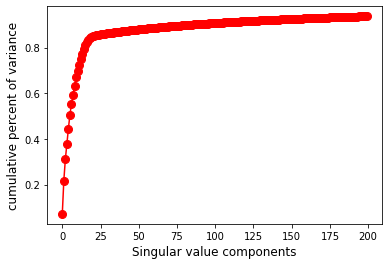

In [30]:
# Compress with SVD (singular value decomposition)
# SVD works very well for the sparse matrix
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('Singular value components', fontsize=12)
plt.ylabel('cumulative percent of variance', fontsize=12)
plt.show()

In [32]:
#number of latent dimensions to keep
n=200
latent_matrix_1_df=pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [33]:
# our content latent matrix:
latent_matrix.shape

(9625, 200)


# Creating a collaborative latent matrix from user ratings:

In [34]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [36]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on='movieId', how='right')

In [43]:
ratings_f1

,movieId,userId,rating
0,1,1,4.0
1,1,7,4.5
2,1,15,2.5
3,1,17,4.5
4,1,18,3.5
...,...,...,...
92724,160341,610,2.5
92725,160527,610,4.5
92726,160836,610,3.0
92727,163937,610,3.5


In [41]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns='userId', values = 'rating').fillna(0)

In [42]:
ratings_f2.head(3)

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [45]:
ratings_f2.shape

(9625, 364)

In [46]:
len(ratings_f.movieId.unique())

9625

In [49]:
from sklearn.decomposition import TruncatedSVD
scd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=Final.title.tolist())

In [50]:
latent_matrix_2_df.shape

(9625, 200)

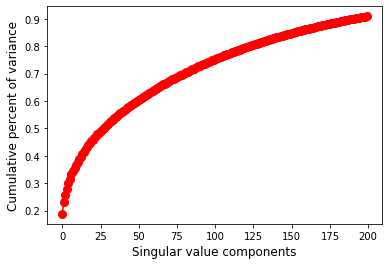

In [52]:
#plot variance explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms=16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [53]:
#This is my content matrix.
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,0.234567,-0.019392,-0.124586,-0.008614,...,-0.032497,-0.134418,-0.043143,0.145434,-0.088043,-0.058114,-0.011443,0.085556,0.026559,-0.005955
Jumanji (1995),0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,0.189676,-0.012325,-0.078054,0.001669,...,0.001222,0.003288,-0.023079,0.010664,0.015974,0.001728,-0.006249,-0.012477,-0.000346,0.029158
Grumpier Old Men (1995),0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,-0.011973,0.000952,0.004727,-0.002093,...,0.006399,-0.005632,0.001505,0.000543,0.000506,0.002536,0.000441,-0.004060,-0.004075,0.006066
Waiting to Exhale (1995),0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,-0.046063,0.001273,0.028399,-0.000377,...,0.000135,-0.000139,0.000247,-0.000035,-0.000170,0.000005,0.000286,-0.000020,-0.000168,-0.000238
Father of the Bride Part II (1995),0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,-0.009221,-0.001934,0.004463,-0.011439,...,0.001208,-0.014851,0.023732,0.012979,0.008908,-0.000236,-0.004764,0.009549,0.009244,-0.012308


In [54]:
#This is my collaborative matrix.
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),36.391240,-4.958788,14.331820,1.844157,-3.077921,-1.351171,8.341428,-0.561087,-1.898204,1.657854,...,-0.284568,1.821130,-0.932767,-1.930437,1.394376,-0.751668,-2.149879,-0.465503,1.439896,-0.911504
Jumanji (1995),20.447499,0.675231,11.354479,-7.325453,-3.505243,3.585614,4.393397,-5.564563,0.434474,0.351435,...,0.341699,-0.508641,0.838471,1.799928,1.850423,-1.592821,0.738655,0.063008,-1.046210,-0.204062
Grumpier Old Men (1995),8.407816,-5.190801,4.378314,-6.189039,-0.333121,1.924148,-1.548363,0.795947,-3.196045,2.121791,...,0.021261,-0.024558,0.077206,-0.225024,0.332259,0.404377,0.930755,-0.449721,1.278904,0.324372
Waiting to Exhale (1995),0.408037,-0.664700,0.739903,-0.202676,-0.498374,1.055409,0.184081,-0.508294,-0.429506,0.086538,...,0.208043,-0.088896,0.000594,0.161013,0.056840,-0.015643,-0.308005,0.209546,-0.130141,-0.042825
Father of the Bride Part II (1995),5.755079,-1.757369,3.961287,-3.673278,-3.688047,3.237859,1.140585,-0.690786,-2.171827,1.365963,...,0.383106,-0.403908,-0.103732,-0.393780,-0.477676,0.144159,0.313400,0.148340,-0.701960,-0.707823


# Running a content/ collaborative and hybrid cosine Similarity:

In [61]:
from sklearn.metrics.pairwise import cosine_similarity
#take the latent vectors for a selected movie from both content and collaborative matrixes
a_1=np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1)
a_2=np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1,-1)

#calculate the similarity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

#an avg measure of both content and collaborative
hybrid = ((score_1 + score_2)/2.0)

#form a data frame of similar movies
dictDf = {'content': score_1, 'collaborative':score_2, 'hybrid':hybrid}
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)

#sort it on the basis of either: content, collaborative or hybrid,
#here : content
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
"Bug's Life, A (1998)",0.901307,0.591832,0.746569
Toy Story 2 (1999),0.778154,0.688699,0.733426
Shrek (2001),0.423949,0.672226,0.548088
"Monsters, Inc. (2001)",0.433832,0.610359,0.522096
Up (2009),0.553247,0.426161,0.489704
Aladdin (1992),0.235383,0.642712,0.439048
Antz (1998),0.433832,0.441279,0.437556
Who Framed Roger Rabbit? (1988),0.358991,0.507358,0.433174
Toy Story 3 (2010),0.355778,0.503356,0.429567
Ice Age (2002),0.380024,0.477317,0.428671
